In [1]:
import sys
print('env executing: ' + sys.executable)

env executing: D:\programs\Continuum\miniconda3\envs\py35\python.exe


In [2]:
# !git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

In [3]:
# !pip install tqdm

In [4]:
import os, cv2, math
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import numpy as np
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from shutil import copyfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


This project is run using google collab GPU.

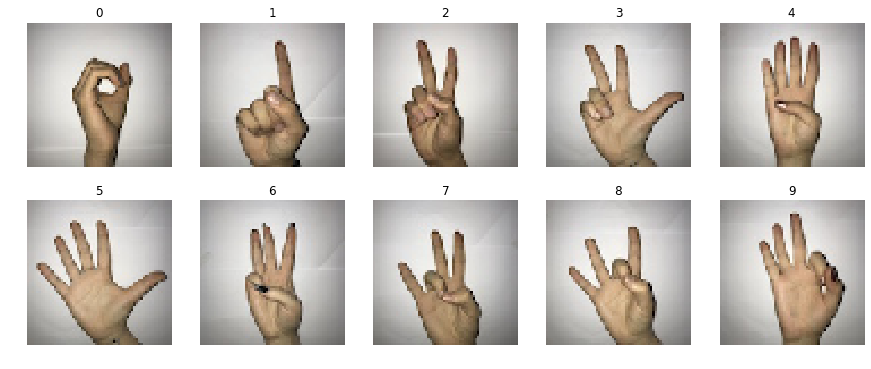

In [5]:
nrow, ncol = 2, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3)
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        # load image
        img = image.load_img('Sign-Language-Digits-Dataset/Examples/example_' + str(img_index) + '.JPG', target_size = (64, 64))
        plt.subplot(nrow, ncol, img_index + 1)
        plt.imshow(img)
        plt.title(img_index)
        plt.axis('off')

This project aims to create a classifier that can intepret sign language for number 0 to 9. The image of the sign language for respective number is shown above.

Inside 'Sign-Language-Digits-Dataset/Dataset/', the images of different sign language are organised according to their labels(i.e. 0 to 9). The dataset will first be divided into 3 sets : training_set, validation_set, and test_set. The size of training set, validation set, and test set are 70%, 15% and 15% of the whole dataset respectively.

To accomodate for the requirement for flow_from_directory method from keras, I will reorganise the images in the following structure :

* Training set : 'Sign-Language-Digits-Dataset/Dataset/training_set/class_00/image_file'
* Validation set : 'Sign-Language-Digits-Dataset/Dataset/validation_set/class_00/image_file'
* Test set : 'Sign-Language-Digits-Dataset/Dataset/test_set/class_00/image_file'

In [6]:
DATASET_PATH = 'Sign-Language-Digits-Dataset/Dataset/'

In [7]:
# Creating a list of filename for training set, validation set, and test set
train_set = {}
validation_set = {}
test_set = {}
for cat in os.listdir(DATASET_PATH):
  cat_dir = os.path.join(DATASET_PATH, cat) # e.g. DATASET_PATH/'0'
  cat_files = os.listdir(cat_dir)
  # Training set's size is 70% of the data
  train_list , test_list = train_test_split(cat_files, test_size = 0.3)
  # Validation set's and Test set's size are both 15% of the data
  validation_list, test_list = train_test_split(test_list, test_size = 0.5)
  train_set[cat] = train_list
  validation_set[cat] = validation_list
  test_set[cat] = test_list

In [8]:
for cat in tqdm(train_set.keys()):
  cat_dir = os.path.join(DATASET_PATH, 'training_set', 'class_0' + str(cat))
  os.makedirs(cat_dir)
  for file in train_set[cat]:
    # src path is DATASET_PATH/'0'/file
    src = os.path.join(DATASET_PATH, cat, file)
    # dest path is DATASET_PATH/'training_set'/'class_00'
    # to accomodate for the directory format required by flow_from_directory method in keras
    dest = os.path.join(cat_dir, file)
    copyfile(src, dest)

100%|██████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


In [9]:
for cat in tqdm(validation_set.keys()):
  cat_dir = os.path.join(DATASET_PATH, 'validation_set', 'class_0' + str(cat))
  os.makedirs(cat_dir)
  for file in validation_set[cat]:
    # src path is DATASET_PATH/'0'/file
    src = os.path.join(DATASET_PATH, cat, file)
    # dest path is DATASET_PATH/'validation_set'/'class_00'
    # to accomodate for the directory format required by flow_from_directory method in keras
    dest = os.path.join(cat_dir, file)
    copyfile(src, dest)

100%|██████████████████████████████████████████| 10/10 [00:02<00:00,  3.58it/s]


In [10]:
for cat in tqdm(test_set.keys()):
  cat_dir = os.path.join(DATASET_PATH, 'test_set', 'class_0' + str(cat))
  os.makedirs(cat_dir)
  for file in test_set[cat]:
    # src path is DATASET_PATH/'0'/file
    src = os.path.join(DATASET_PATH, cat, file)
    # dest path is DATASET_PATH/'test_set'/'class_00'
    # to accomodate for the directory format required by flow_from_directory method in keras
    dest = os.path.join(cat_dir, file)
    copyfile(src, dest)

100%|██████████████████████████████████████████| 10/10 [00:02<00:00,  3.41it/s]


In [11]:
for i in range(10):
  train_size = len(train_set[str(i)])
  validation_size = len(validation_set[str(i)])
  test_size = len(test_set[str(i)])
  print("0{} : Training size({}) Validation size({}) Test size({})".format(i, train_size, validation_size, test_size))

00 : Training size(143) Validation size(31) Test size(31)
01 : Training size(144) Validation size(31) Test size(31)
02 : Training size(144) Validation size(31) Test size(31)
03 : Training size(144) Validation size(31) Test size(31)
04 : Training size(144) Validation size(31) Test size(32)
05 : Training size(144) Validation size(31) Test size(32)
06 : Training size(144) Validation size(31) Test size(32)
07 : Training size(144) Validation size(31) Test size(31)
08 : Training size(145) Validation size(31) Test size(32)
09 : Training size(142) Validation size(31) Test size(31)


Data augmentation is performed on the training set images so that the classifier can learn any changes with respect to scaling, horizontal_flip, or others.

In [12]:
# Performing data augmentation on training dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# For validation dataset, only rescale the pictures
validation_datagen = ImageDataGenerator(rescale = 1./255)

# For test dataset, only rescale the pictures
test_datagen = ImageDataGenerator(rescale = 1./255)

training_data = train_datagen.flow_from_directory(os.path.join(DATASET_PATH, 'training_set'),
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_data = validation_datagen.flow_from_directory(os.path.join(DATASET_PATH, 'validation_set'),
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_data = test_datagen.flow_from_directory(os.path.join(DATASET_PATH, 'test_set'),
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1438 images belonging to 10 classes.
Found 310 images belonging to 10 classes.
Found 314 images belonging to 10 classes.


For this dataset, I will be using the following infrastructure.



In [13]:
# Initialising the CNN
classifier = Sequential()

# Adding first convolutional layer, followed by pooling, and dropout
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Adding second convolutional layer, followed by pooling, and dropout
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Adding third convolutional layer, followed by pooling, and dropout
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 10, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [59]:
# Train the data with training set, and check the result with validation accuracy
history = classifier.fit_generator(training_data,
                         steps_per_epoch = math.ceil(training_data.n / training_data.batch_size),
                         epochs = 10,
                         validation_data = validation_data,
                         validation_steps = math.ceil(validation_data.n / validation_data.batch_size))

Epoch 1/100
45/45 [==============================] - 4s 99ms/step - loss: 2.3166 - acc: 0.1078 - val_loss: 2.2999 - val_acc: 0.2000
Epoch 2/100
45/45 [==============================] - 4s 89ms/step - loss: 2.2987 - acc: 0.1100 - val_loss: 2.2814 - val_acc: 0.2032
Epoch 3/100
45/45 [==============================] - 4s 86ms/step - loss: 2.1714 - acc: 0.2350 - val_loss: 1.7885 - val_acc: 0.4677
Epoch 4/100
45/45 [==============================] - 4s 84ms/step - loss: 1.6709 - acc: 0.4214 - val_loss: 1.3537 - val_acc: 0.5968
Epoch 5/100
45/45 [==============================] - 4s 86ms/step - loss: 1.3323 - acc: 0.5522 - val_loss: 1.1175 - val_acc: 0.6548
Epoch 6/100
38/45 [========================>.....] - ETA: 0s - loss: 1.1436 - acc: 0.605545/45 [==============================] - 4s 88ms/step - loss: 1.1228 - acc: 0.6079 - val_loss: 0.7856 - val_acc: 0.7548
Epoch 7/100
45/45 [==============================] - 4s 83ms/step - loss: 0.9682 - acc: 0.6934 - val_loss: 0.7076 - val_acc: 0.7645

43/45 [===========================>..] - ETA: 0s - loss: 0.0872 - acc: 0.969445/45 [==============================] - 4s 87ms/step - loss: 0.0942 - acc: 0.9666 - val_loss: 0.2337 - val_acc: 0.9387
Epoch 62/100
45/45 [==============================] - 4s 86ms/step - loss: 0.0816 - acc: 0.9750 - val_loss: 0.1878 - val_acc: 0.9613
Epoch 63/100
45/45 [==============================] - 4s 86ms/step - loss: 0.0804 - acc: 0.9729 - val_loss: 0.2179 - val_acc: 0.9452
Epoch 64/100
45/45 [==============================] - 4s 87ms/step - loss: 0.0704 - acc: 0.9778 - val_loss: 0.1301 - val_acc: 0.9742
Epoch 65/100
45/45 [==============================] - 4s 86ms/step - loss: 0.0646 - acc: 0.9757 - val_loss: 0.1568 - val_acc: 0.9613
Epoch 66/100
45/45 [==============================] - 4s 86ms/step - loss: 0.0628 - acc: 0.9748 - val_loss: 0.1773 - val_acc: 0.9710
Epoch 67/100
 6/45 [===>..........................] - ETA: 1s - loss: 0.0278 - acc: 0.989645/45 [==============================] - 4s 87ms

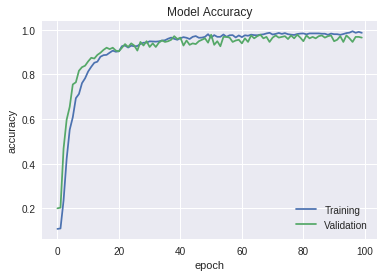

In [60]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'])
plt.savefig('model_peformance.png')

From the accuracy plot, the validation accuracy differs from the training accuracy by a small extent indicating absence of overfitting. When the classifier is evaluated on the test set, it obtains a relatively high accuracy.

In [61]:
# Accuracy of the classifier when evaluated based on the test_set
test_loss, test_accuracy = classifier.evaluate_generator(test_data, math.ceil(test_data.n / test_data.batch_size))
print("Accuracy on test set : {}".format(test_accuracy))

Accuracy on test set : 0.974522290715746


To visualise the performance of the classifier, the classifier will be used to predict all the example images for 0 to 9.

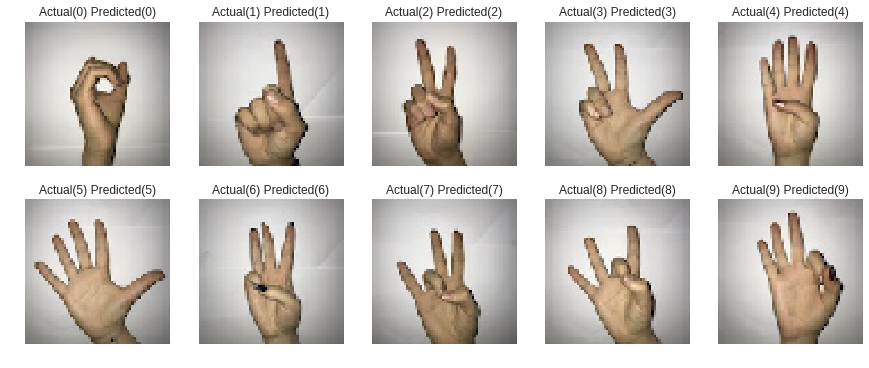

In [73]:
nrow, ncol = 2, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3)
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        # load image
        img = image.load_img('Sign-Language-Digits-Dataset/Examples/example_' + str(img_index) + '.JPG', target_size = (64, 64))
        # convert image into array for prediction
        test_image = image.img_to_array(img)
        test_image = np.expand_dims(test_image, axis = 0)
        # predict image using classifier
        result = classifier.predict(test_image).argmax()
        plt.subplot(nrow, ncol, img_index + 1)
        plt.imshow(img)
        plt.title("Actual({}) Predicted({})".format(img_index, result))
        plt.axis('off')

It can be seen from above output that the classifier is able to classify all the images correctly. To save the model for future use, simply run the code below.

In [48]:
# save the models and weight for future purposes
# serialize model to JSON
model_json = classifier.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
classifier.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Reference

* https://github.com/ardamavi/Sign-Language-Digits-Dataset
* https://www.superdatascience.com/deep-learning/